In [375]:
#these reults have RNN Layers that doesn't work as intended. The Input is likley the reason for that. 
#However, after hours of searching, the error was not found.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATA

In [376]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tqdm

In [377]:
sequencelength = 10

In [378]:
# this functions creates the dataset with the targets, given that the whole series is read
# i am not sure whether this is the right way for the training
def prepare_dataset(input_ds):
    targets = [label.numpy() for img, label in input_ds]
    target_digits = tf.convert_to_tensor(targets, dtype=tf.int32)



    #range_vals is only used to create the change between positive and negative signs for the summation
    range_vals = tf.range(len(targets))
    #this creates the alternating positve and negative signes by checkign whether the entry index modulo 2 is zero 
    #(i.e. even entries are positive, uneven ones negative)
    #check the tf.where documentation if the usage is confusing for you!
    alternating_target_numbers = tf.where(tf.math.floormod(range_vals,2)==0, target_digits, -target_digits)
    #finally we can compute the cumulative sums!
    c_sum = tf.math.cumsum(alternating_target_numbers)
    
    new_targets = tf.data.Dataset.from_tensor_slices(c_sum)

    # create sequences in batches
    new_targets = new_targets.batch(sequencelength, drop_remainder=True)
    input_ds = input_ds.batch(sequencelength, drop_remainder=True)
    
    
    ds = tf.data.Dataset.zip((input_ds, new_targets))
    
    

    # cast datatype to float
    ds = ds.map(lambda img, target: (tf.cast(img[0], tf.float32), target))

    # normalize values
    ds = ds.map(lambda img, target: (img/128. - 1., target))
    


    ds = ds.shuffle(1000) 
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [379]:
(train_dataset, test_dataset), ds_info = tfds.load(
    "mnist", split=["train", "test"], as_supervised=True, with_info=True
)

train_ds = prepare_dataset(train_dataset)
test_ds = prepare_dataset(test_dataset)

In [380]:
for img, label in train_ds.take(1):
    print(img.shape)
    print(label)

#32 batch size 10 sequence length 28*28*1 image dimension

(32, 10, 28, 28, 1)
tf.Tensor(
[[ -64  -70  -62  -63  -60  -67  -65  -74  -69  -69]
 [-268 -273 -270 -276 -268 -269 -267 -272 -264 -265]
 [-374 -383 -381 -387 -382 -387 -381 -385 -383 -389]
 [-128 -130 -125 -126 -126 -128 -126 -126 -125 -129]
 [-189 -191 -190 -197 -197 -200 -195 -202 -196 -199]
 [ -31  -40  -34  -39  -33  -35  -27  -32  -26  -27]
 [-269 -269 -265 -273 -273 -282 -279 -279 -276 -285]
 [-217 -221 -219 -227 -226 -230 -227 -236 -236 -237]
 [ -69  -72  -70  -75  -68  -76  -68  -71  -68  -69]
 [-218 -221 -220 -223 -216 -217 -209 -214 -205 -208]
 [-293 -300 -293 -297 -295 -302 -299 -301 -292 -299]
 [-171 -180 -177 -180 -177 -185 -184 -187 -183 -185]
 [-207 -211 -208 -215 -211 -211 -202 -202 -200 -203]
 [-201 -206 -197 -197 -197 -201 -196 -205 -198 -204]
 [  -7  -14  -13  -16   -9  -12   -9  -14  -11  -16]
 [-146 -150 -145 -149 -143 -145 -141 -148 -142 -150]
 [ -57  -63  -60  -66  -63  -67  -63  -67  -65  -66]
 [-285 -291 -291 -299 -293 -297 -288 -295 -288 -292]
 [-327 -331 -32

In [381]:
#2.3 lstm structure
class customLSTM(tf.keras.layers.AbstractRNNCell):

    def __init__(self, units, **kwargs):
      self.units = units
      super(customLSTM, self).__init__(**kwargs)

    @property
    def state_size(self):
      return [self.units, self.units]

    def output_size(self):
      return self.units    

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return list(
            rnn_utils.generate_zero_filled_state_for_cell(
                self, inputs, batch_size, dtype
            )
        )
    
    def call(self, inputs, states):
        z = backend.dot(inputs, self.kernel)
        z += backend.dot(h_tm1, self.recurrent_kernel)
        
        z = tf.split(z, num_or_size_splits=4, axis=1)
        c, o = self._compute_carry_and_output_fused(z, c_tm1)
        output = o * self.activation(c)
        return output, output

In [382]:
#debug
class debugLSTM(tf.keras.layers.LSTM):
    @property
    def state_size(self):
      return [self.units, self.units]



from tensorflow import keras
from keras.layers import RNN
from keras import backend

# First, let's define a RNN Cell, as a layer subclass.
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = backend.dot(inputs, self.kernel)
        output = h + backend.dot(prev_output, self.recurrent_kernel)
        return output, [output]


In [390]:
#2.2 create cnn structure (inspired by lenet)
#2.4 wrap LSTM-Cell
class Network(tf.keras.Model):
    def __init__(self, optimizer):
        # initialize superclass
        super().__init__()
        self.optimizer = optimizer

        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss"),
            tf.keras.metrics.CategoricalAccuracy()
        ]

        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        # declare layers
        
        input_shape = (32, sequencelength, 28, 28, 1)

        self.conv1 = tf.keras.layers.Conv2D(filters = 6,input_shape=input_shape[2:],
                                            kernel_size = 5, padding="same", activation="sigmoid")
        

        input_shape = (32, sequencelength, 14, 14, 6)

        self.conv2 = tf.keras.layers.Conv2D(filters = 16,input_shape=input_shape[2:],
                                            kernel_size = 5 , padding="valid", activation="sigmoid")
        
        input_shape = (32, sequencelength, 6, 6, 16)

        self.conv3 = tf.keras.layers.Conv2D(filters = 16,input_shape=input_shape[2:],
                                            kernel_size = 6 , padding="same", activation="sigmoid")
        
        self.conv4 = tf.keras.layers.Conv2D(filters = 1,input_shape=input_shape[2:],
                                            kernel_size = (4,1) , padding="valid", activation="softmax")
        self.avgpooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))
        
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.out = tf.keras.layers.Dense(1, activation="softmax")
        
        instanceCell = customLSTM(32)
        #debug
        #instanceCell = debugLSTM(32)

        #instanceCell = MinimalRNNCell(32)
        
        
        self.RNNlayer =  tf.keras.layers.RNN(instanceCell,return_sequences=True)
        

        self.LSTM1 = customLSTM(32)
        

    @tf.function
    def call(self, x):
        #preprocess with cnn
        
        x = self.conv1(x)
        x = tf.keras.layers.TimeDistributed(self.avgpooling)(x)
        x = self.conv2(x)
        x = tf.keras.layers.TimeDistributed(self.avgpooling)(x)
        x = self.conv3(x)
        x = self.conv3(x)
        #x = self.conv4(x)
       
        #calculate with RNN
        
        #RNN call doesn't work
        #likley the input is in the wrong shape
    
        #x = self.RNNlayer(x)
        #x = self.RNNlayer(x)
        
        
        
        #getting into output shape
        #the output is for each element of a time sequence a specific number
        x = tf.keras.layers.TimeDistributed(self.global_pool)(x)
        x = self.out(x)
        
        #clean output shape
        x = tf.squeeze(x)
        
        
        return x
    
 

In [391]:
optimizer = tf.keras.optimizers.Adam()
model = Network(optimizer)
for img, label in train_ds.take(1):
    print(model.call(img).shape)
    
#32 batches and 10 eleements per time sequence(can be increased at the top)

(32, 10)


In [394]:
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

In [396]:

#for img, label in train_ds:

history = model.fit(train_ds, batch_size = 32, epochs = 10)
    
#without the RNN the output is always pointless

Epoch 1/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0023 - false_negatives_4: 0.0000e+00 - categorical_accuracy: 0.0000e+00
Epoch 2/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0023 - false_negatives_4: 0.0000e+00 - categorical_accuracy: 0.0000e+00
Epoch 3/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0023 - false_negatives_4: 0.0000e+00 - categorical_accuracy: 0.0000e+00
Epoch 4/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0023 - false_negatives_4: 0.0000e+00 - categorical_accuracy: 0.0000e+00
Epoch 5/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0023 - false_negatives_4: 0.0000e+00 - categorical_accuracy: 0.0000e+00
Epoch 6/10
188/188 [==============================] - 7s 36ms/step - loss: 0.0000e+00 - binary_accuracy: 

dict_keys(['loss', 'binary_accuracy', 'false_negatives_3', 'categorical_accuracy'])


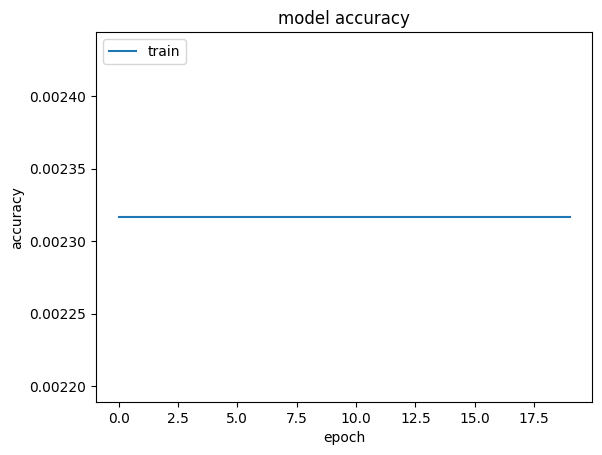

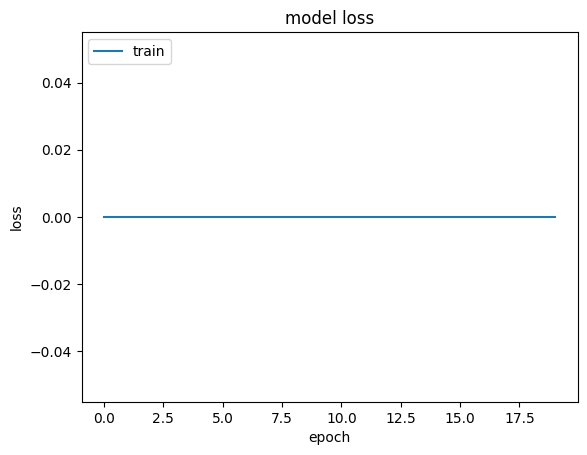

In [387]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()